**DIY FACIAL RECOGNITION MODELING SCRIPT**<BR>
This file allows the user to focus on modeling, rather than image collection and processing, by importing the downstream data files generated by the FaceRecog.jpynb script. There are similarities between these two scripts, but this file is faster and doesn't process any of the image files. Instead, it simply grabs pre-processed data, in the form of a csv file containing Euclidean distances which are calculated from the original image files.

In [14]:
#################
# IMPORT PACKAGES
#################

import pandas as pd
import numpy as np
import random

# for cross-validation
from sklearn.model_selection import cross_validate

# predictive modeling
from sklearn.ensemble import RandomForestClassifier

# for KNN block
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.neighbors import (NeighborhoodComponentsAnalysis, KNeighborsClassifier)
from sklearn.pipeline import Pipeline

# for confusion matrices
import sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

#!pip install pathlib
import pathlib


In [15]:
###################################################################################################################################
# LOCAL VARIABLES: YOU SHOULD NOT NEED TO CHANGE THESE, ASSUMING YOU HAVE UNZIPPED THE FILES AND NOT MOVED ANY ACCOMPANYING FOLDERS
###################################################################################################################################

# because I use dark mode, I use a contrasting color when printing text against the background. You can change this here
textColor = "#cccccc"

# seed for random number generation
seed = 42

# the number of images to use 
targetImagesPerPerson = 110

# tells program whether to use the pre-saved, best train/test split
getTrainTestFromFile = True

# path where .csv file can be found
srcFolder = pathlib.Path("FaceRecog_FromCSV.ipynb").parent.resolve()

# paths to train and test data
pathToDistances = str(srcFolder) + "\\Data_New\\distances.csv"
pathToPoints    = str(srcFolder) + "\\Data_New\\points.csv"
newTrainSavePath = str(srcFolder) + "\\Data_New\\train.csv"
newTestSavePath = str(srcFolder) + "\\Data_New\\test.csv"

In [16]:
################
# GET SAVED DATA
################

# get all data
allDistances = pd.read_csv(pathToDistances)
newCols = allDistances.columns[1:len(allDistances.columns)] # remember the columns we want to keep
allDistances.set_index("Unnamed: 0", inplace=False) # reset the index to the first column's values
allDistances = allDistances[newCols] # remove the old index column

# get train
newTrainDist = pd.read_csv(newTrainSavePath)
newCols = newTrainDist.columns[1:len(newTrainDist.columns)] # remember the columns we want to keep
newTrainDist.set_index("Unnamed: 0", inplace=False) # fix columns
newTrainDist = newTrainDist[newCols] # remove the old index column

# get test data
newTestDist = pd.read_csv(newTestSavePath)
newTestDist.set_index("Unnamed: 0", inplace=False)
newTestDist = newTestDist[newCols] # remove the old index column

# separate train into x and y variables 
y_train = newTrainDist["personID"]
X_train = newTrainDist[newTrainDist.columns[2:len(newTrainDist.columns)]]

# separate test into x and y variables 
y_test = newTestDist["personID"]
X_test = newTestDist[newTestDist.columns[2:len(newTestDist.columns)]]

In [17]:
##########################################################################################################################
# SCRUB: CLEAN UP DIFFERENT PERSON NAMES
# note: this only affects KNN, since KNN uses raw data. The other models use the train/test split that has been pre-loaded
##########################################################################################################################

# determine which columns we reall need
colsToKeep = ["person"] + list(allDistances.columns[2:len(allDistances.columns)])

ad = allDistances[colsToKeep]                       # get a local copy of allDistances df
ad["person"] = ad["person"].apply(str.lower)        # change case of person to lower

# fix person names where they are duplicates
ad["person"][ad["person"] == "sandras"] = "sandys"  
ad["person"][ad["person"] == "andrew"] = "andrewd"  
ad["person"][ad["person"] == "anniet"] = "annieti"  
ad["person"][ad["person"] == "davidl"] = "davidla"  
ad["person"][ad["person"] == "garenm"] = "garenmo"  
ad["person"][ad["person"] == "jiebin"] = "jiebinz"  
ad["person"][ad["person"] == "joshua"] = "joshuab"  
ad["person"][ad["person"] == "karltr"] = "karltre"  
ad["person"][ad["person"] == "katieh"] = "katieha"  
ad["person"][ad["person"] == "leiche"] = "leichen"  
ad["person"][ad["person"] == "nickwa"] = "nickwai"
ad["person"][ad["person"] == "noahla"] = "noahlar"
ad["person"][ad["person"] == "noefer"] = "noefern"
ad["person"][ad["person"] == "sethri"] = "sethris"

C:\Users\KETRE~1.WIN\AppData\Local\Temp/ipykernel_5172/2842849652.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ad["person"] = ad["person"].apply(str.lower)        # change case of person to lower
C:\Users\KETRE~1.WIN\AppData\Local\Temp/ipykernel_5172/2842849652.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ad["person"][ad["person"] == "sandras"] = "sandys"
C:\Users\ketre.WINDOWS-H8826EH\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

In [18]:
##########################################################################################################################
# TRANSFORM:  TURN person COLUMN INTO personID COLUMN
# note: this only affects KNN, since KNN uses raw data. The other models use the train/test split that has been pre-loaded
##########################################################################################################################

ad = ad.sort_values(by="person")                    # sort by person
p = ad["person"].unique()                           # get one copy of each person
i = list(range(0,len(p)))                           # get an index for the table that will translate people into numbers
pID = pd.DataFrame(data=p, index=i)
pID.columns = ["person"]
pID['personID'] = pID.index

ad = pd.merge(ad, pID, how="inner", on="person")
ad = ad[["personID"] + list(ad.columns[1:len(ad.columns)-1])]

# take a look at the transformed data frame
ad.head()

,personID,dist_0,dist_1,dist_2,dist_3,dist_4,dist_5,dist_6,dist_7,dist_8,...,dist_126,dist_127,dist_128,dist_129,dist_130,dist_131,dist_132,dist_133,dist_134,dist_135
0,0,173.994253,187.856328,158.050625,178.241409,165.529454,170.815690,165.000000,155.080624,155.913438,...,111.305885,121.494856,142.284925,109.224539,90.022219,117.341382,50.089919,120.332872,92.195445,114.109596
1,0,154.945152,181.231896,140.698259,170.064694,157.000000,169.446157,167.585799,157.292721,168.023808,...,111.198022,110.860272,129.003876,97.416631,91.197588,103.097042,62.096699,104.809351,94.429868,100.603181
2,0,177.132719,189.763010,155.116086,175.262660,163.975608,171.723615,167.523133,156.064089,166.207701,...,101.833197,113.534136,129.034879,105.385008,86.005814,112.929181,52.345009,112.641023,87.005747,105.304321
3,0,184.390889,195.601636,164.109719,181.727818,171.432202,179.724790,179.178682,166.709328,168.576392,...,105.990566,131.244047,128.097619,113.745330,87.051709,120.166551,55.901699,128.444541,88.814413,122.588743
4,0,171.592541,195.058965,152.069063,176.638048,162.542302,171.420536,169.685002,153.495928,165.511329,...,95.603347,120.415946,117.613775,108.295891,79.762146,113.053085,50.596443,114.982607,80.062476,109.293184


In [19]:
##########################################################################################################################
# SCRUB: REMOVE ANY PERSONS WHO DON'T HAVE A MINIMUM NUMBER OF IMAGES
# note: this only affects KNN, since KNN uses raw data. The other models use the train/test split that has been pre-loaded
##########################################################################################################################

personsRemoved = pID.copy(deep=True)

# for each person, make sure there are a minimum number of images
for i in pID["personID"]:
    # get the number of images we have for this person
    c = len(ad[ad["personID"] == i])
    # if we have fewer than the minimum number, remove that person from the data
    if c < targetImagesPerPerson: 
        ad = ad[ad["personID"] != i]
    else: 
        # otherwise, note down the fact that they won't have their image removed
        personsRemoved = personsRemoved[personsRemoved["personID"] != i]
        # get ids we'll cull (and leave as many as we need to build a good model)
        imagesToCull = random.sample(list(ad.index[ad["personID"] == i]), c-targetImagesPerPerson)
        
        prsn = pID["person"][i]

        print("We will remove {} images from {}. Previous total was {}".format(len(imagesToCull), prsn, c))
        # remove the extra images
        ad.drop(imagesToCull, inplace=True)


print("\n\nAll images were removed for the following individuals due to insufficient number of images:\n{}".format(personsRemoved))



We will remove 16 images from andrewd. Previous total was 126
We will remove 31 images from annieti. Previous total was 141
We will remove 4 images from christi. Previous total was 114
We will remove 23 images from davidla. Previous total was 133
We will remove 29 images from farahin. Previous total was 139
We will remove 9 images from garenmo. Previous total was 119
We will remove 121 images from jessika. Previous total was 231
We will remove 151 images from jiebinz. Previous total was 261
We will remove 143 images from jonfox. Previous total was 253
We will remove 16 images from joshuab. Previous total was 126
We will remove 426 images from karltre. Previous total was 536
We will remove 263 images from katieha. Previous total was 373
We will remove 114 images from leichen. Previous total was 224
We will remove 88 images from matthew. Previous total was 198
We will remove 59 images from nickwai. Previous total was 169
We will remove 154 images from noahlar. Previous total was 264
We w

In [20]:
################################
# EXPLORE: PREVIEW ALL DISTANCES
################################
ad.head()

,personID,dist_0,dist_1,dist_2,dist_3,dist_4,dist_5,dist_6,dist_7,dist_8,...,dist_126,dist_127,dist_128,dist_129,dist_130,dist_131,dist_132,dist_133,dist_134,dist_135
0,0,173.994253,187.856328,158.050625,178.241409,165.529454,170.815690,165.000000,155.080624,155.913438,...,111.305885,121.494856,142.284925,109.224539,90.022219,117.341382,50.089919,120.332872,92.195445,114.109596
3,0,184.390889,195.601636,164.109719,181.727818,171.432202,179.724790,179.178682,166.709328,168.576392,...,105.990566,131.244047,128.097619,113.745330,87.051709,120.166551,55.901699,128.444541,88.814413,122.588743
4,0,171.592541,195.058965,152.069063,176.638048,162.542302,171.420536,169.685002,153.495928,165.511329,...,95.603347,120.415946,117.613775,108.295891,79.762146,113.053085,50.596443,114.982607,80.062476,109.293184
5,0,167.107750,209.121974,157.892368,194.177754,175.547714,187.296556,179.824915,155.241747,170.496334,...,105.621967,124.338248,130.391718,112.071406,87.321246,115.121675,54.129474,114.934764,88.294960,112.111552
6,0,140.427917,175.251248,137.568165,166.138496,158.398232,164.201096,168.077363,147.353317,169.026625,...,96.767763,125.143917,116.619038,111.543713,77.646635,117.004273,43.011626,123.664870,79.624117,117.426573


In [21]:
###################################################################################
# REPORTING: BUILD RANDOM FOREST
# note: this uses pre-loaded train/test data, NOT the allDistances or ad dataframes
###################################################################################

forest = RandomForestClassifier(n_estimators = 80, criterion="entropy", random_state = np.random.seed(seed))
#forest = RandomForestClassifier(n_estimators = 100, criterion="gini", random_state = np.random.seed(seed))

#### WARNING! CROSS-VALIDATION INDICATES THAT OUR MODEL IS NOT AS ACCURATE AS IT SEEMS ####
cv = cross_validate(forest, X_train, y_train, cv=10)
print("k-fold cross validation")
print(cv['test_score'])
print(cv['test_score'].mean())

forest.fit(X=X_train, y=y_train)
predictions = forest.predict(X_test)

def getNameFromID(id):
    return(pID.iloc[id]["person"])
    
y_test
names = []
testPersonID = 0
predictedPersonID = 0
testName = ""
predictedName = ""

df = pd.DataFrame({"test":y_test, "predict":list(predictions)})
df = df.reset_index(drop=True)
for i in df.index:    
    testPersonID = df.iloc[i]["test"]
    predictedPersonID = df.iloc[i]["predict"]
    testName = pID.iloc[testPersonID]["person"]
    predictedName = pID.iloc[predictedPersonID]["person"]
    names.append([testName, predictedName])

names = pd.DataFrame(names)
df["correctName"] = names[0]
df["predictedName"] = names[1]
df["correct"] = (df["test"] == df["predict"]).astype(int)

dfCorrect = df[["correctName", "correct"]].groupby(by="correctName").sum()
dfCorrect.reset_index()
dfCorrect["total"] = df[["correctName", "correct"]].groupby(by="correctName").count()
dfCorrect["pctCorrect"] = round(dfCorrect["correct"] / dfCorrect["total"] * 100,2)
dfCorrect = dfCorrect.reset_index(drop=False)
dfCorrect = dfCorrect.sort_values(by="correctName")

print("Result: {}% correct".format(round(sum(dfCorrect["correct"])/sum(dfCorrect["total"]) * 100, 2)))

# show confusion matrix
print(sklearn.metrics.confusion_matrix(y_test, predictions))

k-fold cross validation
[0.86363636 0.88068182 0.81818182 0.85795455 0.86363636 0.92045455
 0.8125     0.90340909 0.88068182 0.83522727]
0.8636363636363636
Result: 88.86% correct
[[21  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 16  0  0  0  0  0  0  2  0  0  3  0  0  0  1  0  0  0  0]
 [ 0  0 22  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0 21  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 22  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 21  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0 18  0  0  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  2  1  0  0  0  0 15  1  0  0  0  0  2  0  0  1  0  0  0]
 [ 0  1  0  1  0  0  0  1 17  0  0  2  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 22  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  1  0 19  0  0  0  0  1  0  0  0  0]
 [ 0  1  1  0  1  0  0  1  0  0  2 16  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 22  0  0  0  0  0  0  0]
 [

,correctName,correct,total,pctCorrect
0,andrewd,21,22,95.45
1,annieti,16,22,72.73
2,christi,22,22,100.00
3,davidla,21,22,95.45
4,farahin,22,22,100.00
5,garenmo,21,22,95.45
6,jessika,18,22,81.82
7,jiebinz,15,22,68.18
8,jonfox,17,22,77.27
9,joshuab,22,22,100.00


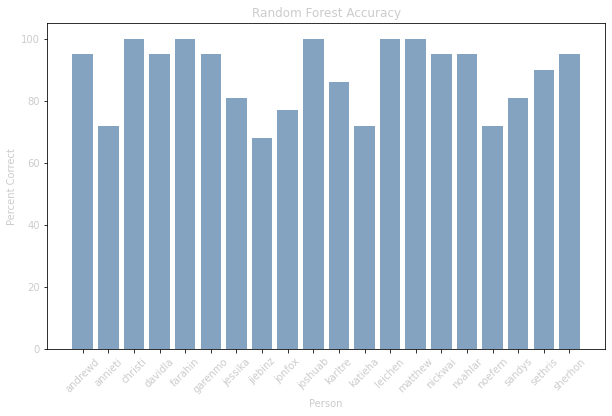

In [22]:
# Random forest accuracy

# create bar plot of random forest accuracy
plt.figure(figsize=(10,6))
# color formatting: https://www.python-graph-gallery.com/3-control-color-of-barplots
plt.bar("correctName", dfCorrect["pctCorrect"].astype(int), width=.8, color=(0.2, 0.4, 0.6, 0.6), align='center', data=dfCorrect)
plt.xticks(color=textColor, rotation = 45)
plt.yticks(color=textColor)
plt.title("Random Forest Accuracy", color=textColor)
plt.xlabel("Person", color=textColor)
plt.ylabel("Percent Correct", color=textColor)

dfCorrect


**Random Forest Notes**<br>
Random forest was the winner for the Euclidean Distance data. With 100% correct classification for several persons, and a mean success rate ~86% with models generated at random. 

In [23]:
###################################################################################
# MODELING 2: TRY BAYESIAN MODEL
# note: this uses pre-loaded train/test data, NOT the allDistances or ad dataframes
###################################################################################

# MODEL
# Initialize our classifier
gnb = GaussianNB()

# Train our classifier
model = gnb.fit(X_train, y_train)

# nb cross-validation
cv = cross_validate(model, X_train, y_train, cv=10)
print("k-fold cross validation")
print(cv['test_score'])
print(cv['test_score'].mean())

# Make predictions
predictions = gnb.predict(X_test)

# print accuracy
print(accuracy_score(y_test, predictions) * 100)

bayesPredictions = pd.DataFrame({"test":y_test, "predict":list(predictions)})

# show confusion matrix
print(sklearn.metrics.confusion_matrix(y_test, predictions))

k-fold cross validation
[0.5625     0.63636364 0.59090909 0.63068182 0.58522727 0.63068182
 0.63068182 0.64772727 0.61363636 0.61931818]
0.6147727272727271
62.5
[[11  0  0  2  1  4  0  0  0  0  0  1  0  0  0  1  1  1  0  0]
 [ 1 11  0  1  0  1  0  1  2  0  1  3  0  0  0  1  0  0  0  0]
 [ 0  0 20  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0]
 [ 3  1  0 17  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  1  0  0 17  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0 19  0  0  0  0  0  0  0  0  0  0  2  0  0  0]
 [ 1 10  0  2  0  0  3  0  1  0  0  0  0  0  2  2  0  1  0  0]
 [ 0  0  1  0  0  0  2  9  1  1  0  1  0  2  0  0  5  0  0  0]
 [ 1  0  0  0  0  0  1  1 11  0  0  3  0  2  2  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  3  0 19  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  3  0  0 10  0  1  2  0  1  5  0  0  0]
 [ 0  1  0  0  0  0  1  5  0  0  1  8  0  2  1  0  1  0  2  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0 18  0  0  0  0  0  0  3]
 [ 0  0  0  0  0  1 

Result: 62.5% correct


,correctName,correct,total,pctCorrect
0,andrewd,11,22,50.00
1,annieti,11,22,50.00
2,christi,20,22,90.91
3,davidla,17,22,77.27
4,farahin,17,22,77.27
5,garenmo,19,22,86.36
6,jessika,3,22,13.64
7,jiebinz,9,22,40.91
8,jonfox,11,22,50.00
9,joshuab,19,22,86.36


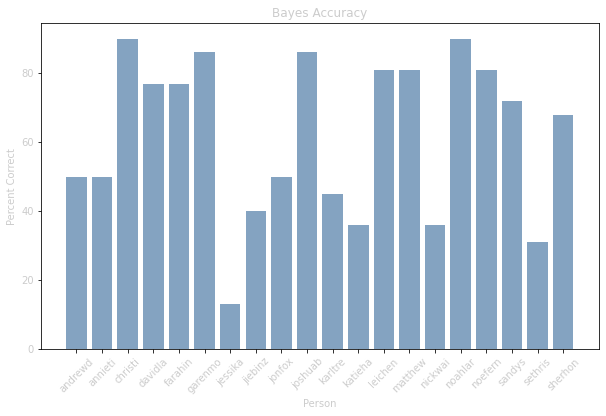

In [24]:
########################################
# REPORTING: BAYESIAN ACCURACY BY PERSON
########################################

df = bayesPredictions.copy(deep=True)

def getNameFromID(id):
    return(pID.iloc[id]["person"])
    
y_test
names = []
testPersonID = 0
predictedPersonID = 0
testName = ""
predictedName = ""

df = df.reset_index(drop=True)
for i in df.index:    
    testPersonID = df.iloc[i]["test"]
    predictedPersonID = df.iloc[i]["predict"]
    testName = pID.iloc[testPersonID]["person"]
    predictedName = pID.iloc[predictedPersonID]["person"]
    names.append([testName, predictedName])

names = pd.DataFrame(names)
df["correctName"] = names[0]
df["predictedName"] = names[1]
df["correct"] = (df["test"] == df["predict"]).astype(int)

dfCorrect = df[["correctName", "correct"]].groupby(by="correctName").sum()
dfCorrect.reset_index()
dfCorrect["total"] = df[["correctName", "correct"]].groupby(by="correctName").count()
dfCorrect["pctCorrect"] = round(dfCorrect["correct"] / dfCorrect["total"] * 100,2)
dfCorrect = dfCorrect.reset_index(drop=False)
dfCorrect = dfCorrect.sort_values(by="correctName")

print("Result: {}% correct".format(round(sum(dfCorrect["correct"])/sum(dfCorrect["total"]) * 100, 2)))

# create bar plot of Bayes accuracy
plt.figure(figsize=(10,6))
# color formatting: https://www.python-graph-gallery.com/3-control-color-of-barplots
plt.bar("correctName", dfCorrect["pctCorrect"].astype(int), width=.8, color=(0.2, 0.4, 0.6, 0.6), align='center', data=dfCorrect)
plt.xticks(color=textColor, rotation = 45)
plt.yticks(color=textColor)
plt.title("Bayes Accuracy", color=textColor)
plt.xlabel("Person", color=textColor)
plt.ylabel("Percent Correct", color=textColor)

dfCorrect


**Note**<br>
Everything below (KNN) is created from the allDistances data that is loaded in at the top of this file. This is as opposed to the train/test data, which is pre-loaded and used for the Bayesian and Random Forest models. Ultimately, everything was derived from the same dataset. It is simply faster, and easier to reliably recreate the other models, with the pre-loaded train/test data.

In [25]:
#####################
# MODELING 3: TRY KNN
#####################
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NeighborhoodComponentsAnalysis.html

neighbors = 3

#nca = NeighborhoodComponentsAnalysis(max_iter=10, tol=1e-5, random_state=seed)
knn = KNeighborsClassifier(n_neighbors=neighbors, weights="distance", algorithm="ball_tree", metric="minkowski", p=2, n_jobs=-1)

# nb cross-validation
cv = cross_validate(forest, X_train, y_train, cv=10)
print("k-fold cross validation")
print(cv['test_score'])
print(cv['test_score'].mean())

nca_pipe = Pipeline([('nca', nca), ('knn', knn)])
nca_pipe.fit(X_train, y_train)

yhat = nca_pipe.predict(X_test)

y_yhat = pd.DataFrame({"test":y_test, "predict":yhat})
y_yhat["result"] = y_yhat["test"] == y_yhat["predict"]
y_yhat["result"] = y_yhat["result"].astype(int)

print("Result: {}% correct".format(round(sum(y_yhat["result"])/len(y_yhat)*100, 2)))

# show confusion matrix
print(sklearn.metrics.confusion_matrix(y_test, yhat))

k-fold cross validation
[0.88068182 0.85795455 0.81818182 0.84659091 0.84659091 0.91477273
 0.83522727 0.88636364 0.84659091 0.82954545]
0.85625
Result: 85.23% correct
[[21  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 11  0  0  0  1  2  2  2  0  0  3  0  0  0  0  1  0  0  0]
 [ 0  0 22  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  2  0 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 22  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  1  1  0  0  0]
 [ 0  0  0  1  0  0 20  0  0  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  1  1  0  0  0  0 15  0  1  0  0  0  0  0  0  2  1  0  1]
 [ 0  1  0  1  0  0  0  0 19  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0 22  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  3  0  0  0  0  0  0  0 17  0  0  0  0  2  0  0  0  0]
 [ 0  2  0  1  1  0  0  1  1  0  1 12  0  0  0  0  1  0  1  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 22  0  0  0  0  0  0  0]
 [ 0  0  0  0

Result: 86.59% correct


,correctName,correct,total,pctCorrect
0,andrewd,21,22,95.45
1,annieti,15,22,68.18
2,christi,22,22,100.00
3,davidla,17,22,77.27
4,farahin,22,22,100.00
5,garenmo,20,22,90.91
6,jessika,15,22,68.18
7,jiebinz,16,22,72.73
8,jonfox,17,22,77.27
9,joshuab,22,22,100.00


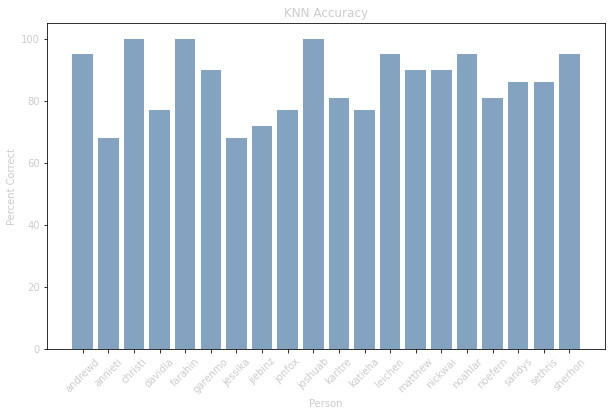

In [ ]:
###################################
# REPORTING: KNN ACCURACY BY PERSON
###################################

df = y_yhat.copy(deep=True)

def getNameFromID(id):
    return(pID.iloc[id]["person"])
    
y_test
names = []
testPersonID = 0
predictedPersonID = 0
testName = ""
predictedName = ""

df = df.reset_index(drop=True)
for i in df.index:    
    testPersonID = df.iloc[i]["test"]
    predictedPersonID = df.iloc[i]["predict"]
    testName = pID.iloc[testPersonID]["person"]
    predictedName = pID.iloc[predictedPersonID]["person"]
    names.append([testName, predictedName])

names = pd.DataFrame(names)
df["correctName"] = names[0]
df["predictedName"] = names[1]
df["correct"] = (df["test"] == df["predict"]).astype(int)

dfCorrect = df[["correctName", "correct"]].groupby(by="correctName").sum()
dfCorrect.reset_index()
dfCorrect["total"] = df[["correctName", "correct"]].groupby(by="correctName").count()
dfCorrect["pctCorrect"] = round(dfCorrect["correct"] / dfCorrect["total"] * 100,2)

print("Result: {}% correct".format(round(sum(y_yhat["result"])/len(y_yhat)*100, 2)))
dfCorrect = dfCorrect.reset_index(drop=False)
dfCorrect = dfCorrect.sort_values(by="correctName")

# create bar plot of KNN accuracy
plt.figure(figsize=(10,6))
# color formatting: https://www.python-graph-gallery.com/3-control-color-of-barplots
plt.bar("correctName", dfCorrect["pctCorrect"].astype(int), width=.8, color=(0.2, 0.4, 0.6, 0.6), align='center', data=dfCorrect)
plt.xticks(color=textColor, rotation = 45)
plt.yticks(color=textColor)
plt.title("KNN Accuracy", color=textColor)
plt.xlabel("Person", color=textColor)
plt.ylabel("Percent Correct", color=textColor)

dfCorrect